# Item-Item Collaborative Filtering

In this section we create an item-item collaborative filter using Cosine Similarity and Euclidean Distance. The basic premise is to treat each movie as a vector in an N-dimensional vector space where N is the number of users who have submitted sufficient ratings to the database. We then measure the similarities between movies by taking the cosine of each movie. Cosine is a useful measurement because if the vectors are the same, cosine is 1 and if they are completely different then cosine is 0. We would even be able to tell if movies are opposite if we scale the data properly since oppositely directed vectors have cosine of -1.

Euclidean distance works on a different premise. The user ratings are all still treated as vectors in a vector space, but instead of measuring likeness by measuring the direction of the vector, like in cosine similarity, the vectors are treated as positions, and similar movies will have similar positions. This distance is measured using variant of the Pythagorean Theorem. 

## Data Preprocessing - Exploratory Data Analysis

Our first step is to pull in the useful modules we will need to use and then pull the data into the program. After that we need to put the data into a format that is useful for testing.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
# Perform the necessary imports
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances
%matplotlib notebook

In [2]:
#These Data, which connect data frame ID to popular internet database 
#id numbers proved not to be useful, so I commented them out,
#in case we need them later 
path = "C:\\Users\\Nate\\Documents\\DataSet\\MovieLens"
#links_df = pd.read_csv((path + "\\links.csv"))
#links_df.head()

In [3]:
#These data are useful for connecting the titles to the id numbers
movies_df = pd.read_csv((path + "\\movies.csv"))
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
#These data are what we use to build our space for similarity testing.
ratings_df = pd.read_csv((path + "\\ratings.csv"))
ratings_df = ratings_df.drop(['timestamp'], axis=1)
ratings_wide_df = ratings_df.pivot(index='userId', columns = 'movieId', values = 'rating')
ratings_wide_trns_df = ratings_df.pivot(index='movieId', columns = 'userId', values = 'rating')
print(ratings_wide_df.shape)
print(ratings_wide_df.info())
print(ratings_wide_trns_df.head())

(671, 9066)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 1 to 671
Columns: 9066 entries, 1 to 163949
dtypes: float64(9066)
memory usage: 46.4 MB
None
userId   1    2    3    4    5    6    7    8    9    10  ...   662  663  664  \
movieId                                                   ...                   
1        NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  4.0  NaN ...   NaN  4.0  3.5   
2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   5.0  NaN  NaN   
3        NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
5        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   

userId   665  666  667  668  669  670  671  
movieId                                     
1        NaN  NaN  NaN  NaN  NaN  4.0  5.0  
2        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
3        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
4        NaN  NaN  NaN  NaN  NaN  NaN  

In [5]:
#Tags proved no to be useful so they are commented ou for now
#tags_df = pd.read_csv((path + "\\tags.csv"))
#tags_df.head()

In [6]:
#This shows the data its original format. we will be using data 
#where the movies are the observations and the users are the catagories.
#it is the same as below, but rotated 90 degrees.
#sns.heatmap(ratings_wide_df)

This heatmap shows that the data is somewhat sparse. The white indicates missing data. We will truncate some of this as users or movies with few ratings can bias the results.

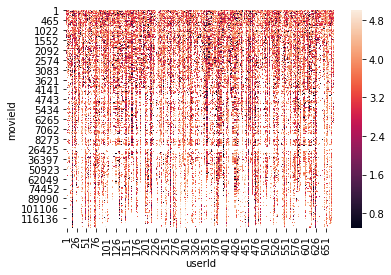

In [7]:
sns.heatmap(ratings_wide_trns_df)

This shows the distribution of the ratings. We can see fractional ratings were allowed. However, most ratings are integer numbers. The data is left skewed with a mode at 4.0. This seems correct, as most viewers will know their taste well and will avoid movies they do not like. 

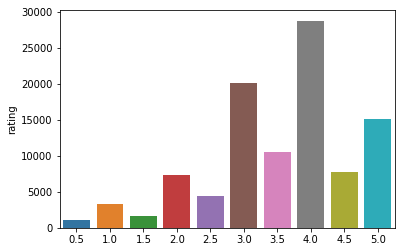

In [8]:
sns.barplot(x=ratings_df['rating'].value_counts().index, y=ratings_df['rating'].value_counts())
plt.show()

The next two code blocks are used to see the distribtions of the ratings themselves. This way, I can truncate the data in a way that will not exclude too much.  The first block counts ratings along rows, for the untransformed data that is the numbers of ratings for each user. The second block counts data in each column and gives a total number of movie ratings.

671
149.03725782414307
20.0


C:\Users\Nate\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


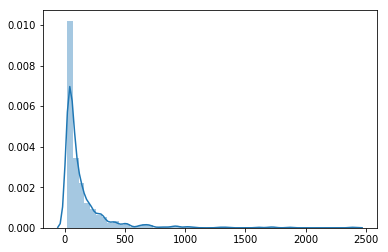

In [9]:
def rowCounts(df):
    j = []
    for index, row in df.iterrows():
        i=0
        for n in row:
            if n > 0:
                i = i +1
        j.append(i)
    return j
ratings_user_counts = rowCounts(ratings_wide_df)
print(len(ratings_user_counts))
print(np.mean(ratings_user_counts))
print(np.percentile(ratings_user_counts,.95))
sns.distplot(ratings_user_counts)
plt.show()

Here we see the average rater has about 149 ratings, and that 95% have above 20 ratings. However, their are some power-users that have ratings in the thousands. We will cut the data off at the 95% mark or more than 20 ratings.

9066
11.030664019413193


C:\Users\Nate\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


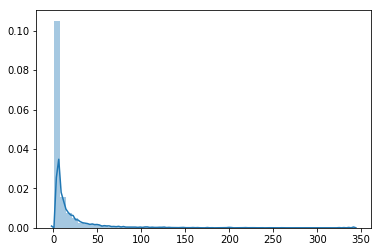

In [10]:
def colCounts(df):
    j = []
    for k,col in df.iteritems():
        i=0
        for n in col:
            if n > 0:
                i = i +1
        j.append(i)
    return j
ratings_movie_counts = colCounts(ratings_wide_df)
print(len(ratings_movie_counts))
print(np.mean(ratings_movie_counts))
sns.distplot(ratings_movie_counts)
plt.show()

Here we see that the mode for movie ratings has a mode around 10 ratings per movie. Very few movies have more than 50 views. There seem to be a considerable number of obscure movies in the data. This is harder to call. We will set the limit at 5 ratings per movie, to include the peak. 

## Data Preprocessing - Filtering and Shaping the Data

Our first step is to merge the title data in the movies data frame with the ratings in the ratings dataframe, so that we can maintain a human-readable identity to each movie throughout the process.

Next, we filter out the rows and columns with too few entries at the thersholds discussed in the previous section. 

Finally,  we rescale the data from being 1-5 with NaNs for no data to being 0(for no view) to pi/2. This is beacuse cosine uses radians as a degree measure and radians range from pi/2 to 0. 

In [11]:
#trim out users that have seen few movies and movies that mave been seem to few times.
ratings_df = ratings_df.merge(movies_df, on='movieId', how='inner') # add titles
relevent_ratings_df = ratings_df.groupby('userId').filter(lambda x: x['userId'].count()>20) #filter out users
relevent_ratings_df = relevent_ratings_df.groupby('movieId').filter(lambda x: x['movieId'].count()>5)#filter out movies
relevent_ratings_df['rating'] = relevent_ratings_df['rating']/(10.0/math.pi)#rescale ratings to be cosine-friendly
print(relevent_ratings_df.head())
print(relevent_ratings_df.shape)

   userId  movieId    rating                   title genres
1       7       31  0.942478  Dangerous Minds (1995)  Drama
2      31       31  1.256637  Dangerous Minds (1995)  Drama
3      32       31  1.256637  Dangerous Minds (1995)  Drama
4      36       31  0.942478  Dangerous Minds (1995)  Drama
5      39       31  0.942478  Dangerous Minds (1995)  Drama
(87534, 5)


We can see in the heat map below, that the user-item matrix looks less sparse. 

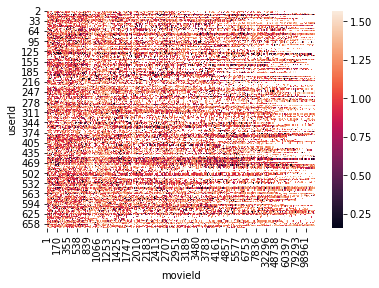

In [12]:
relevent_ratings_wide_df = relevent_ratings_df.pivot(index='userId', columns = 'movieId', values = 'rating')
#print(relevent_ratings_wide_df)
sns.heatmap(relevent_ratings_wide_df)

# Building the Recommeder Engines

Now that the data has been preprocessed we can now build recommeder engines using the cosine similarity method and the euclidean distance method.

Although we do not evaluate the models in the project, we did include training and test sets for futher analysis at a later date. The models will be applied to the training set which consists of 70027 user ratings across 3097 movies.

In [13]:
rating_train, rating_test = train_test_split(relevent_ratings_df, test_size = 0.2, random_state = 42) 

In [14]:
print(rating_train.shape)
print(rating_test.shape)

(70027, 5)
(17507, 5)


In [15]:
ratings_train_wide = rating_train.pivot(index='title', columns = 'userId', values = 'rating')
ratings_test_wide = rating_train.pivot(index='title', columns = 'userId', values = 'rating')

To build the cosine similarity model we must use the data cast into a wide format with the rows as the movies and the columns as the user ratings. The missing values are set to 0 as the cosine_similarity function from sci-kit learn cannot handle NaN values.

The output of cosine similarity is a numpy array of size 3097x3097 which is what we expect for the movies. The array is a matrix of the similarities of each movie with self-similarities being 1.

A similar procedure is used for the distanances with similar results. The result is a matrix of 3097 distances for 3097 movies.

In [16]:
ratings_train_wide = ratings_train_wide.fillna(0)
similarities = cosine_similarity(ratings_train_wide,dense_output=False)
distances = euclidean_distances(ratings_train_wide)

In [23]:
#len(similarities)
print(similarities.shape)
print(distances.shape)

(3097, 3097)
(3097, 3097)


In [18]:
print(np.sort(similarities[0:6,0:6]))

[[0.         0.03621327 0.0516715  0.07821204 0.15566867 1.        ]
 [0.04614982 0.0516715  0.11723288 0.21030506 0.23407022 1.        ]
 [0.04368057 0.07821204 0.08801629 0.11723288 0.22282826 1.        ]
 [0.         0.04614982 0.07969432 0.08801629 0.15566867 1.        ]
 [0.03621327 0.04368057 0.07909901 0.07969432 0.23407022 1.        ]
 [0.         0.         0.07909901 0.21030506 0.22282826 1.        ]]


In [19]:
print(np.sort(distances[0:6,0:6]))

[[0.         4.24986777 4.56883063 5.08996184 8.17719816 8.35480563]
 [0.         7.1294083  7.3609869  7.99410336 8.17719816 9.0848537 ]
 [0.         2.27630014 4.15593644 4.56883063 7.3609869  7.65833691]
 [0.         3.80249529 4.15593644 5.08996184 7.99410336 8.00489891]
 [0.         7.39609913 7.65833691 8.00489891 8.35480563 9.0848537 ]
 [0.         2.27630014 3.80249529 4.24986777 7.1294083  7.39609913]]


In [20]:
item_item_cosine = pd.DataFrame(similarities, index=ratings_train_wide.index, columns = ratings_train_wide.index)
print(item_item_cosine.nlargest(10,'\'burbs, The (1989)')[['\'burbs, The (1989)']])
print(item_item_cosine.nlargest(10,'Ghostbusters II (1989)')[['Ghostbusters II (1989)']])
print(item_item_cosine.nlargest(10,'Dangerous Minds (1995)')[['Dangerous Minds (1995)']])
print(item_item_cosine.nlargest(10,'Contact (1997)')[['Contact (1997)']])

title                                'burbs, The (1989)
title                                                  
'burbs, The (1989)                             1.000000
History of the World: Part I (1981)            0.387939
Wayne's World 2 (1993)                         0.354819
Clue (1985)                                    0.340935
Ghostbusters II (1989)                         0.333453
Friday the 13th Part 3: 3D (1982)              0.332434
Dogma (1999)                                   0.331925
So I Married an Axe Murderer (1993)            0.329095
Needful Things (1993)                          0.326949
Dungeons & Dragons (2000)                      0.325010
title                      Ghostbusters II (1989)
title                                            
Ghostbusters II (1989)                   1.000000
Sleepy Hollow (1999)                     0.456997
Batman Returns (1992)                    0.451905
Insomnia (2002)                          0.433891
RoboCop (1987)              

Above are the results for 4 different movies in the item-item similarity matrix which we cast as a data frame to make exploration easier. The 'burbs (1989) is a Horror/Comedy film with Supernatural elements about a group of paranoid suburbanites who spy on some creepy neighbors. We can see that the recommended movies are Comedies: History of the World: Part I (1981), Wayne's World 2 (1993); Suspence/Comedies:  Clue (1985),  So I Married an Axe Murderer (1993); Supernatural Comedies:
Ghostbusters II (1989), Dogma (1999), Dungeons & Dragons (albeit unintentionally, 2000); and Horror movies: Needful Things (1993) and Friday the 13th Part 3: 3D (1982). So for each film there seems to be something that ties all these movies together in terms of themes.

Similary for Contact (1997) which is a somewhat dark Sci-Fi drama about humanities first contact with Aliens and how NASA scientist cope with it, we see Sci-Fi featuring aliens are heavy in the list: Total Recall (1990), Star Wars: Episode IV - A New Hope (1977), Star Wars: Episode VI - Return of the Jedi (1983), Alien (1979). There are also Dark Sci-Fi Dramas: Blade Runner (1982), Matrix, The (1999). One drama that deals with Governments: Hunt for Red October, The (1990). The only odd one out seems to be Austin Powers: International Man of Mystery (1997). This may be in the list because both films were in theaters at similar times and both were highly regarded. This time-proximity may have affected the scoring.

In [22]:
item_item_dist = pd.DataFrame(distances, index=ratings_train_wide.index, columns = ratings_train_wide.index)
print(item_item_dist.nsmallest(10,'\'burbs, The (1989)')[['\'burbs, The (1989)']])
print(item_item_dist.nsmallest(10,'Ghostbusters II (1989)')[['Ghostbusters II (1989)']])
print(item_item_dist.nsmallest(10,'Dangerous Minds (1995)')[['Dangerous Minds (1995)']])
print(item_item_dist.nsmallest(10,'Contact (1997)')[['Contact (1997)']])

title                                           'burbs, The (1989)
title                                                             
'burbs, The (1989)                                        0.000000
Friday the 13th Part 3: 3D (1982)                         3.904938
Radioland Murders (1994)                                  4.004761
Cabin Boy (1994)                                          4.029330
Dungeons & Dragons (2000)                                 4.044610
Miss Congeniality 2: Armed and Fabulous (2005)            4.044610
Needful Things (1993)                                     4.074998
Iron Eagle (1986)                                         4.078024
Red Sonja (1985)                                          4.078024
Cocoon: The Return (1988)                                 4.084070
title                                               Ghostbusters II (1989)
title                                                                     
Ghostbusters II (1989)                        

The Distance metric yeilds very different results. Altough there are some repeats: The 'burbs (1989) with Friday the 13th Part 3: 3D (1982), Dungeons & Dragons (2000) and Needful Things (1993), Ghostbusters II (1989) with RoboCop 2 (1990), Dangerous Minds (1995) with Now and Then (1995) and Drop Zone (1994). There doesn't seems to be as much thematic overlap as the cosine method. 

My hypothesis is that the cosine method will evaluate better than the distance method. This is based on the fact that I have seen the movies I reported here. For the Cosine Method, I have seen most of the movies the method recommended for each film and enjoyed most of them, or I could at least see the connection if I didn't enjoy the movie. For the distance method, I have not seen most of the recommended films. 